没有障碍物，dqn

In [10]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import os
import envlx_xiangdui
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
env = envlx_xiangdui.DroneEnv()

In [11]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [12]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q




In [13]:
class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [14]:
lr = 2e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
#env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(state_dim )
print(action_dim)
#print(env.observation_space)
#print(env.action_space)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')


4
3


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]

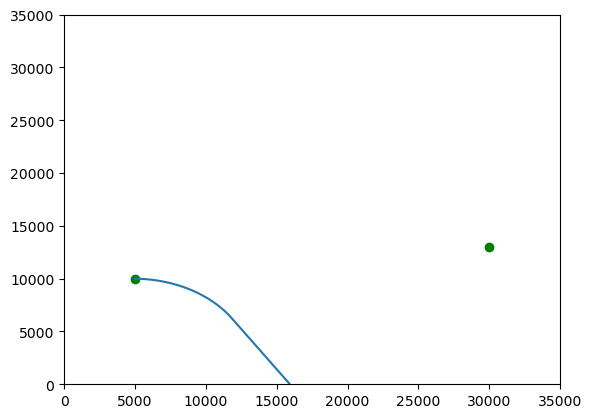

Iteration 0:   1%|          | 1/100 [00:00<00:44,  2.21it/s]

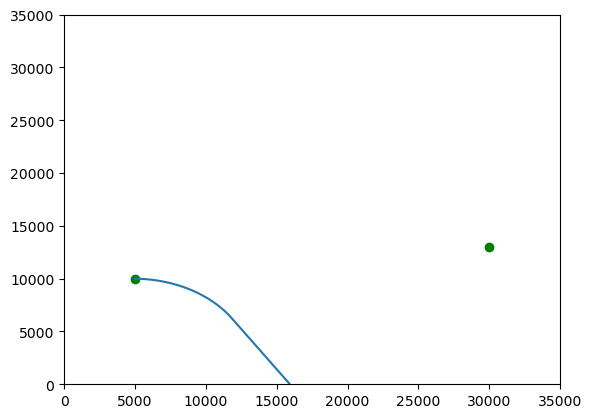

Iteration 0:   2%|▏         | 2/100 [00:00<00:42,  2.33it/s]

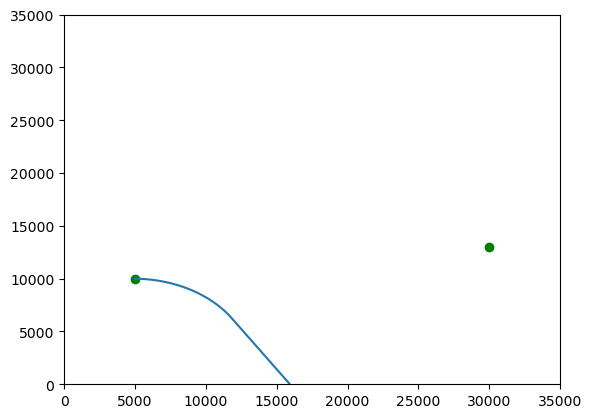

Iteration 0:   3%|▎         | 3/100 [00:01<00:41,  2.34it/s]

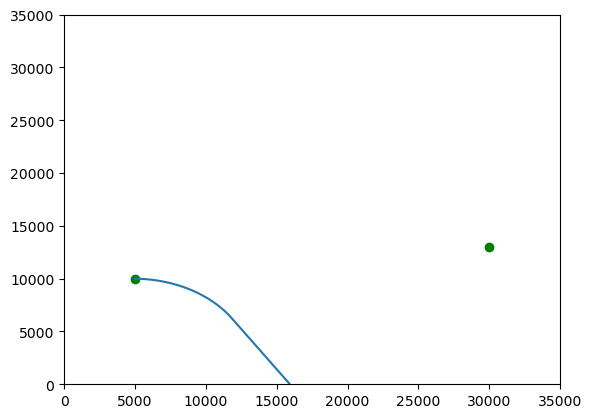

Iteration 0:   4%|▍         | 4/100 [00:01<00:41,  2.31it/s]

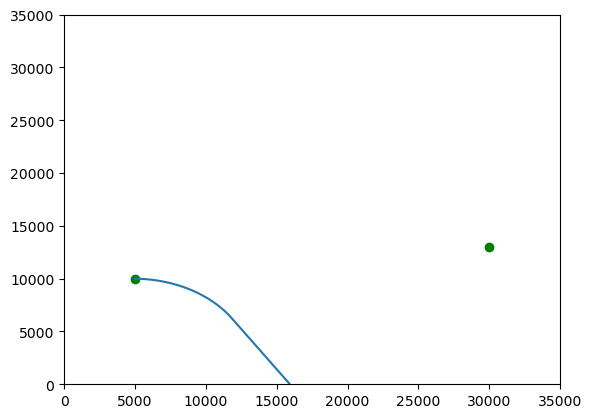

Iteration 0:   5%|▌         | 5/100 [00:02<00:40,  2.35it/s]

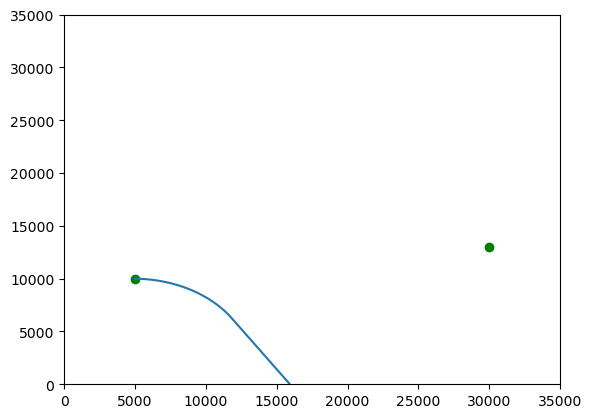

Iteration 0:   6%|▌         | 6/100 [00:02<00:39,  2.38it/s]

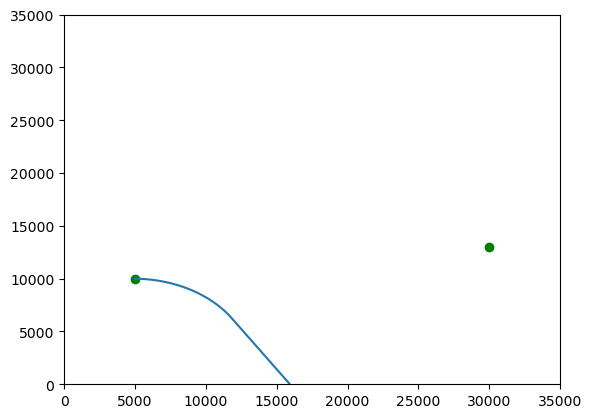

Iteration 0:   7%|▋         | 7/100 [00:02<00:38,  2.40it/s]

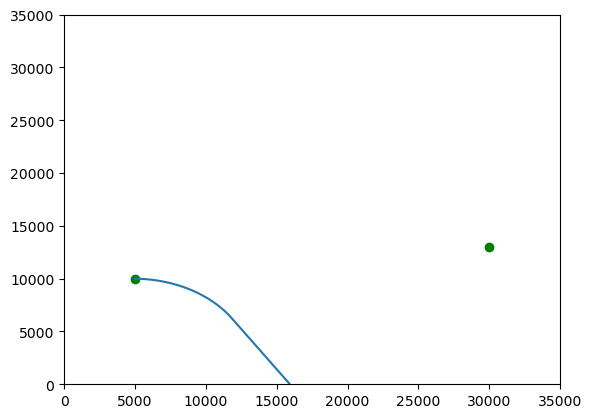

Iteration 0:   8%|▊         | 8/100 [00:04<00:56,  1.61it/s]

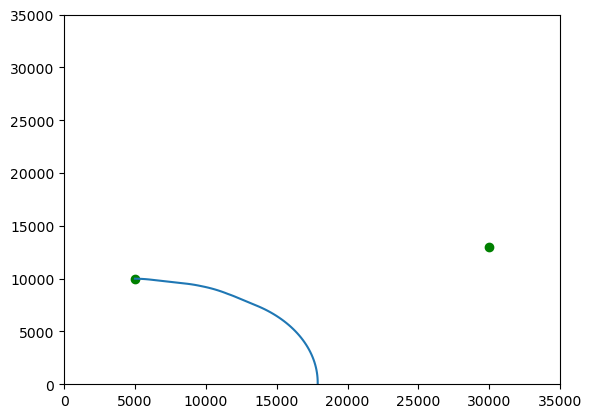

Iteration 0:   9%|▉         | 9/100 [00:04<01:00,  1.51it/s]

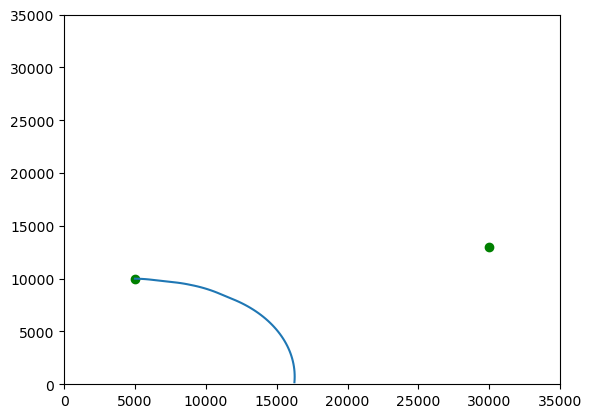

Iteration 0:  10%|█         | 10/100 [00:05<01:00,  1.48it/s, episode=10, return=-13302.245]

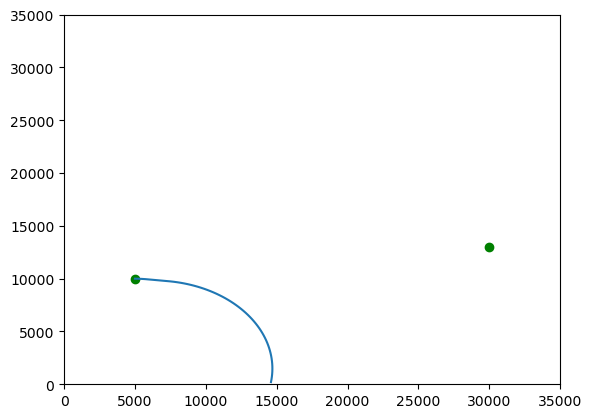

Iteration 0:  11%|█         | 11/100 [00:06<00:59,  1.49it/s, episode=10, return=-13302.245]

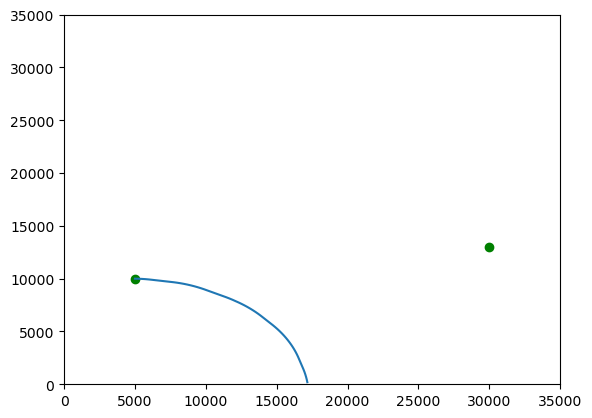

Iteration 0:  12%|█▏        | 12/100 [00:06<01:00,  1.46it/s, episode=10, return=-13302.245]

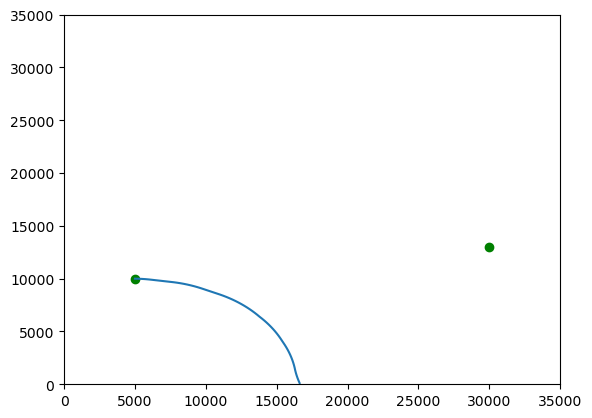

Iteration 0:  13%|█▎        | 13/100 [00:07<01:00,  1.43it/s, episode=10, return=-13302.245]

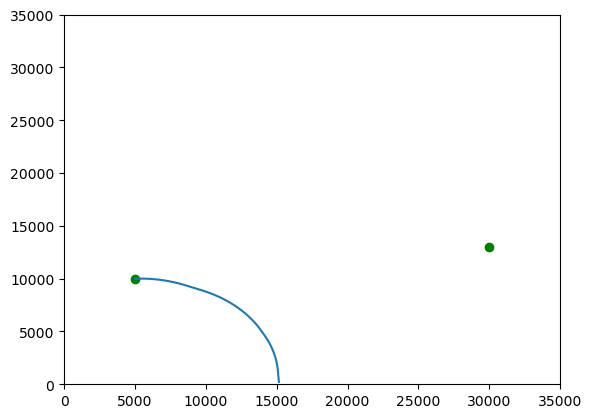

Iteration 0:  14%|█▍        | 14/100 [00:08<00:59,  1.44it/s, episode=10, return=-13302.245]

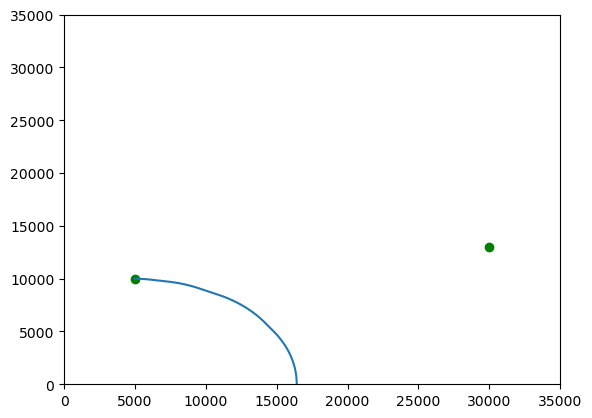

Iteration 0:  15%|█▌        | 15/100 [00:09<01:00,  1.41it/s, episode=10, return=-13302.245]

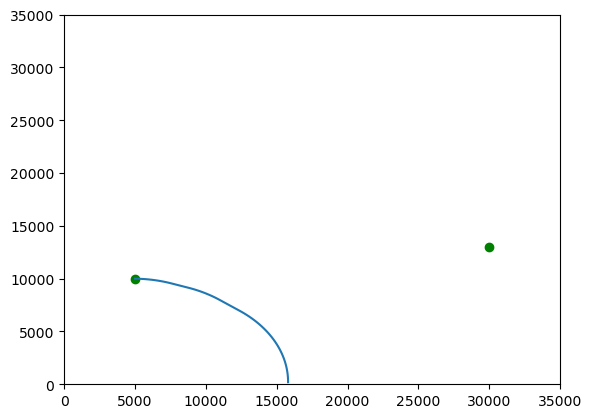

Iteration 0:  16%|█▌        | 16/100 [00:09<01:03,  1.32it/s, episode=10, return=-13302.245]

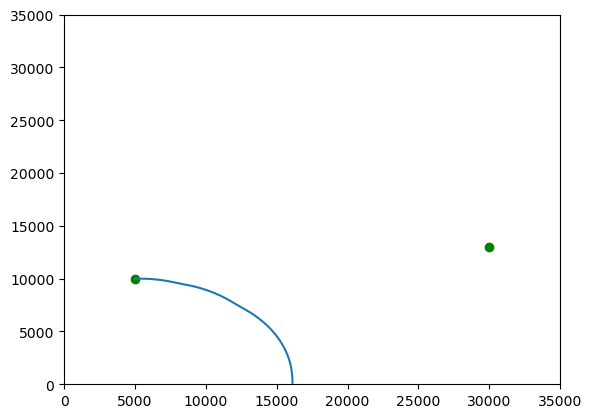

Iteration 0:  17%|█▋        | 17/100 [00:10<01:04,  1.29it/s, episode=10, return=-13302.245]

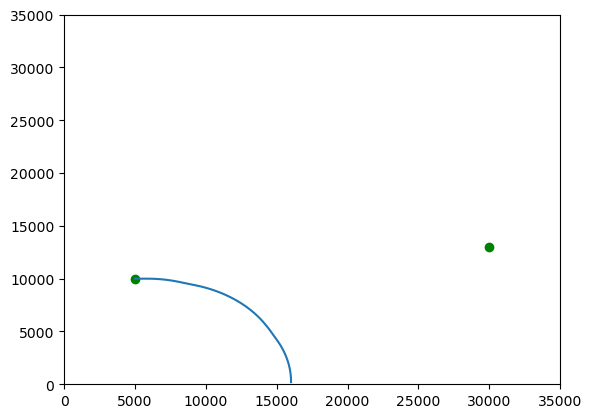

Iteration 0:  18%|█▊        | 18/100 [00:11<01:04,  1.27it/s, episode=10, return=-13302.245]

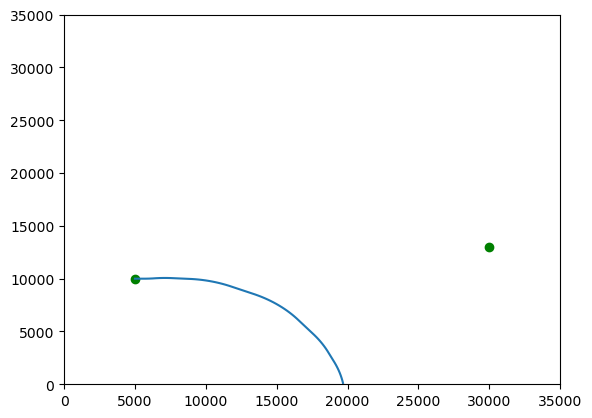

Iteration 0:  19%|█▉        | 19/100 [00:12<01:07,  1.21it/s, episode=10, return=-13302.245]

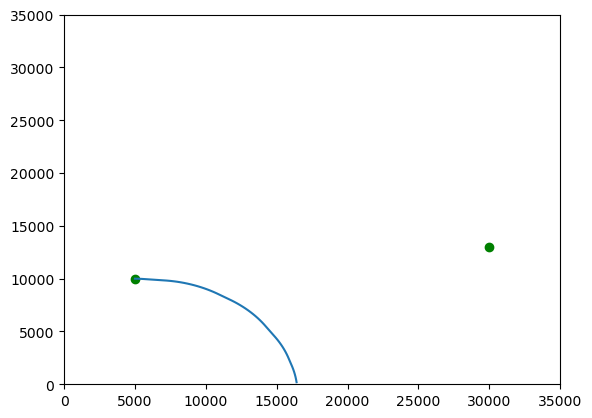

Iteration 0:  20%|██        | 20/100 [00:13<01:02,  1.28it/s, episode=20, return=-13566.642]

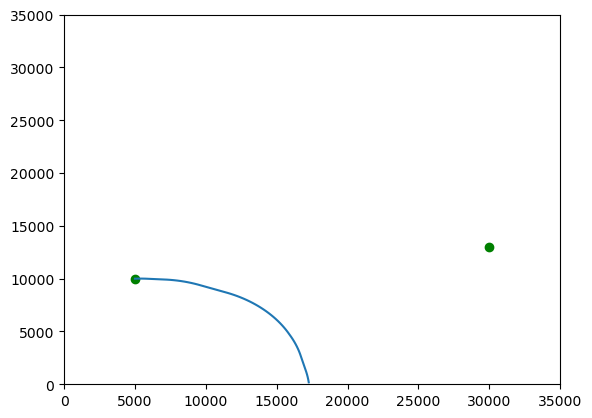

Iteration 0:  21%|██        | 21/100 [00:13<01:00,  1.32it/s, episode=20, return=-13566.642]

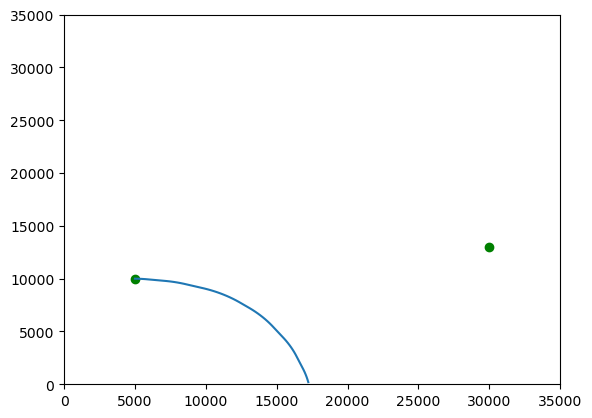

Iteration 0:  22%|██▏       | 22/100 [00:14<00:57,  1.36it/s, episode=20, return=-13566.642]

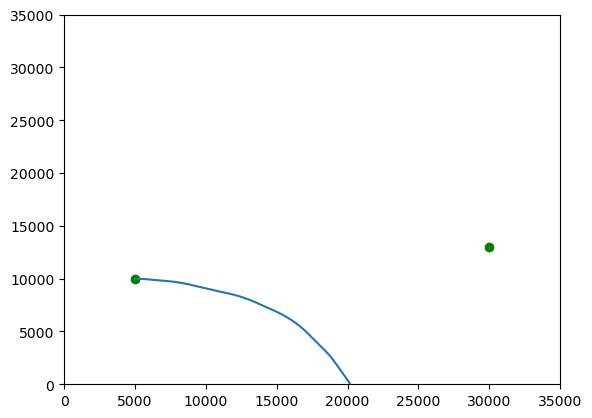

Iteration 0:  23%|██▎       | 23/100 [00:15<00:55,  1.38it/s, episode=20, return=-13566.642]

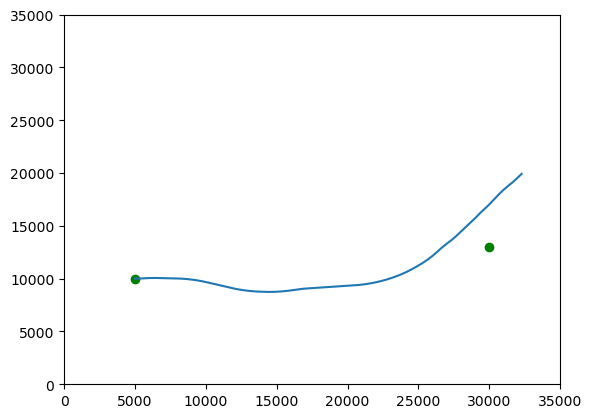

Iteration 0:  24%|██▍       | 24/100 [00:16<01:01,  1.24it/s, episode=20, return=-13566.642]

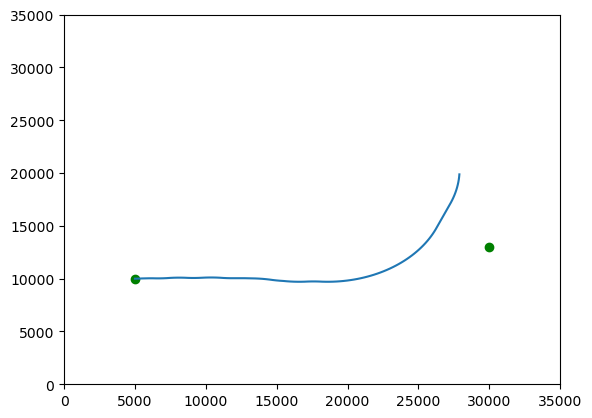

Iteration 0:  25%|██▌       | 25/100 [00:17<00:52,  1.43it/s, episode=20, return=-13566.642]


KeyboardInterrupt: 

In [15]:
#训练模型
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            #绘制x,y轴
            X=[]
            Y=[]
            count = 0
            while not done:
                X.append(env.goal[0] - state[0])
                Y.append(env.goal[1] - state[1])
                count+=1
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                if (count>500):
                    done = True
            #画图可视化
            plt.plot(5000, 10000, 'go')  # 'ro'表示红色的点
            plt.plot(30000, 13000, 'go')  # 'ro'表示红色的点
            #plt.plot(50, 50, 'ro',markersize=env.r_obstacles)#障碍物
            plt.xlim(0, 35000)
            plt.ylim(0, 35000)
            plt.plot(X,Y)
            plt.pause(0.1)  # 暂停一段时间，可以根据需要调整
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
        plt.show()

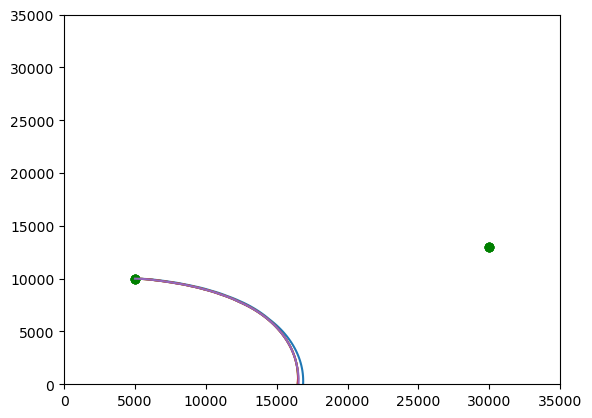

In [7]:
for i in range(5):
    state = env.reset()
    done = False
     #绘制x,y轴
    X=[]
    Y=[]
    while not done:
        X.append(env.goal[0] - state[0])
        Y.append(env.goal[1] - state[1])
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)

        state = next_state

     #画图可视化
    plt.plot(5000, 10000, 'go')  # 'ro'表示红色的点
    plt.plot(30000, 13000, 'go')  # 'ro'表示红色的点
    #plt.plot(50, 50, 'ro',markersize=env.r_obstacles)#障碍物
    plt.xlim(0, 35000)
    plt.ylim(0, 35000)
    plt.plot(X,Y)
plt.show()

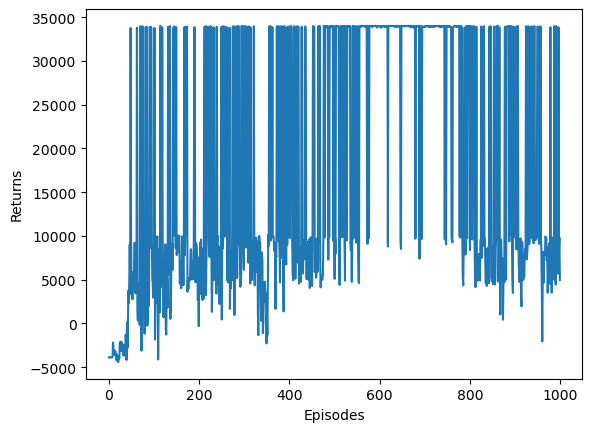

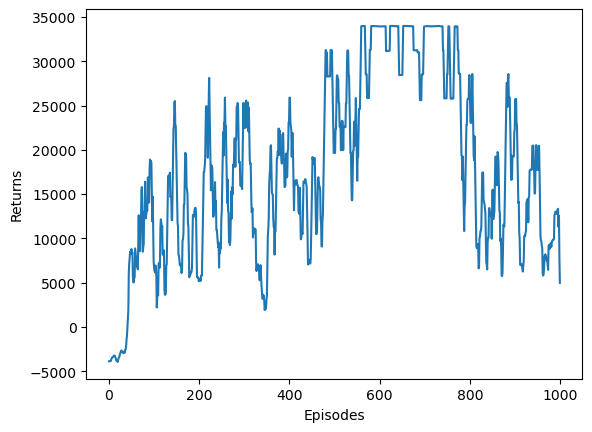

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('DQN on {}'.format(env_name))
plt.show()

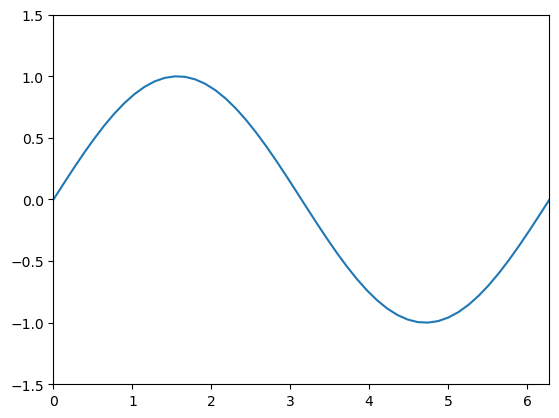

In [10]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)